In [1]:
import numpy as np
import pandas as pd
from io_f import read_data_file
from glob import glob
from pathlib import Path

root="C:\\Users\\Chan Li Long\\Documents\\IndoorChallenge\\indoor-location-navigation"

trainTrajFiles = glob(f"{root}\\train\\*\\*")
metaFiles = glob(f"{root}\\metadata\\*\\*")
metaRoot= f"{root}\\metadata\\"


trainDF = pd.DataFrame({"TrajFolders":trainTrajFiles})
trainDF["ID"] = trainDF["TrajFolders"].apply(lambda x: x.split("\\")[-2])
trainDF["floor"] = trainDF["TrajFolders"].apply(lambda x: x.split("\\")[-1])
trainDF["subFiles"] = trainDF["TrajFolders"].apply(lambda x: glob(x+"\\*.txt"))
trainDF["floorImage"] = trainDF[["ID","floor"]].apply(lambda x: metaRoot+f"\\{x.ID}\\{x.floor}\\floor_image.png",axis=1)
trainDF["floorInfo"] = trainDF[["ID","floor"]].apply(lambda x: metaRoot+f"\\{x.ID}\\{x.floor}\\floor_info.json",axis=1)
trainDF["floorGeoJson"] = trainDF[["ID","floor"]].apply(lambda x: metaRoot+f"\\{x.ID}\\{x.floor}\\geojson_map.json",axis=1)

trainDF.head()

,TrajFolders,ID,floor,subFiles,floorImage,floorInfo,floorGeoJson
0,C:\Users\Chan Li Long\Documents\IndoorChalleng...,5a0546857ecc773753327266,B1,[C:\Users\Chan Li Long\Documents\IndoorChallen...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...
1,C:\Users\Chan Li Long\Documents\IndoorChalleng...,5a0546857ecc773753327266,F1,[C:\Users\Chan Li Long\Documents\IndoorChallen...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...
2,C:\Users\Chan Li Long\Documents\IndoorChalleng...,5a0546857ecc773753327266,F2,[C:\Users\Chan Li Long\Documents\IndoorChallen...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...
3,C:\Users\Chan Li Long\Documents\IndoorChalleng...,5a0546857ecc773753327266,F3,[C:\Users\Chan Li Long\Documents\IndoorChallen...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...
4,C:\Users\Chan Li Long\Documents\IndoorChalleng...,5a0546857ecc773753327266,F4,[C:\Users\Chan Li Long\Documents\IndoorChallen...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...,C:\Users\Chan Li Long\Documents\IndoorChalleng...


In [2]:
from io_f import read_data_file
from compute_f import compute_step_positions as csp

# path_filename = trainDF["subFiles"].values[0][0]

# path_datas = read_data_file(path_filename)
# acce_datas = path_datas.acce
# magn_datas = path_datas.magn
# ahrs_datas = path_datas.ahrs
# wifi_datas = path_datas.wifi
# ibeacon_datas = path_datas.ibeacon
# posi_datas = path_datas.waypoint

# step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
# step_positions2 = csp(acce_datas, ahrs_datas, posi_datas)

In [3]:
# waypoints = []
paths = trainDF["subFiles"].values[0]
allSensors = []
for path in paths:
    path_datas = read_data_file(path)
    allSensors.append(path_datas)
    # acce_datas = path_datas.acce
    # magn_datas = path_datas.magn
    # ahrs_datas = path_datas.ahrs
    # wifi_datas = path_datas.wifi
    # ibeacon_datas = path_datas.ibeacon
    # posi_datas = path_datas.waypoint
    # waypoints.append(posi_datas)


In [4]:
wp.shape,mags.shape,iBeac.shape,wifiCat.shape

NameError: name 'wp' is not defined

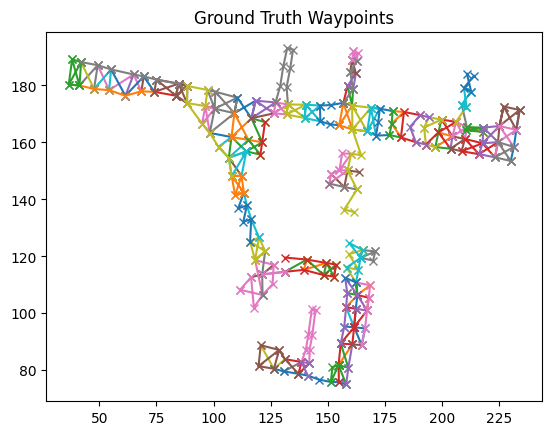

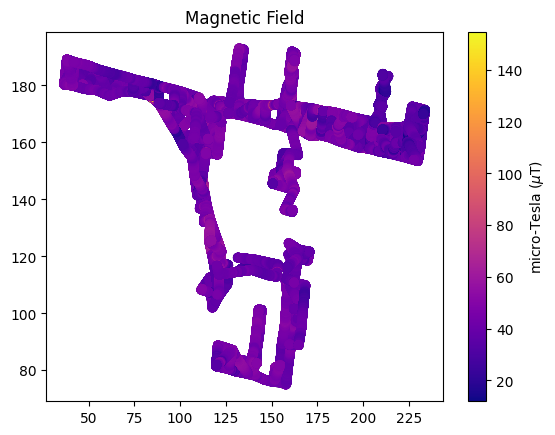

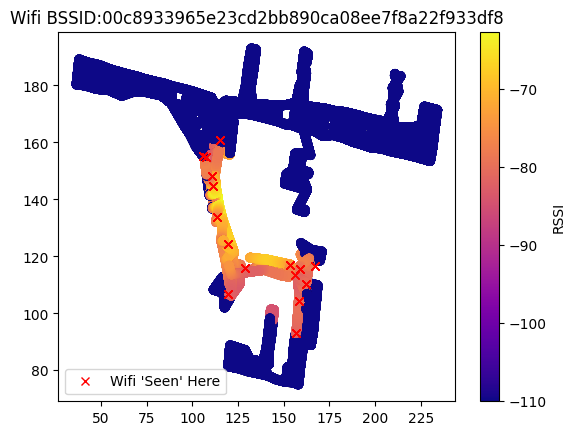

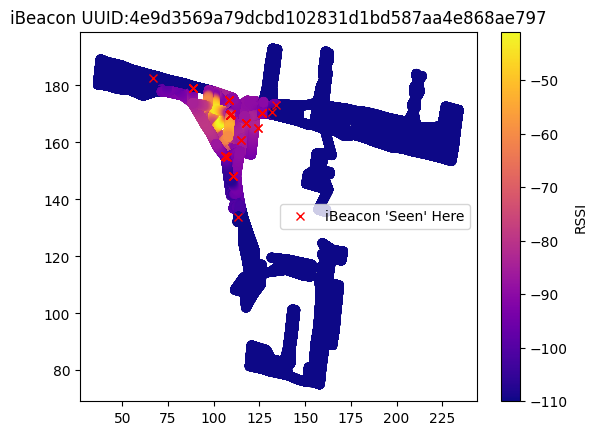

In [13]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator,interp1d,interpn
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

wp = np.concatenate([x.waypoint for x in allSensors])
mags = np.concatenate([x.magn for x in allSensors])
iBeac = np.concatenate([x.ibeacon for x in allSensors])
wifiCat = np.concatenate([x.wifi for x in allSensors])

idx = np.argsort(wp[:,0])
wpSorted = wp[idx]


beacID = np.unique(iBeac[:,1])[2]

wifiBSSID = np.unique(wifiCat[:,2])[3]
f = wifiCat[:,2]==wifiBSSID

wifiSignal = wifiCat[f][:,[0,3]].astype(np.float32)

interp = interp1d(wp[:,0],wp[:,1:],axis=0,fill_value="extrapolate")
wifiPos = interp(wifiSignal[:,0])

magSort = np.argsort(mags[:,0])
magVal = np.linalg.norm(mags[magSort,1:],axis=1)

# interp = interp1d(wpSorted[:,0],wpSorted[:,1:],axis=0,fill_value="extrapolate",kind="linear")
# magnPos = interp(mags[magSort,0])

interp = interp1d(wp[:,0],wp[:,1:],axis=0,fill_value="extrapolate",kind="linear")
magnPos = interp(mags[:,0])

beacData = iBeac[iBeac[:,1]==beacID][:,[0,2]].astype(np.float32)
beacDataSort = beacData[beacData[:,0].argsort()]

interp = interp1d(wp[:,0],wp[:,1:],axis=0,fill_value="extrapolate")
beacPos = interp(beacDataSort[:,0])

for s in allSensors:
    w = s.waypoint
    plt.plot(w[:,1],w[:,2],"x-")
plt.title("Ground Truth Waypoints")
plt.show()

sc = plt.scatter(magnPos[:,0],magnPos[:,1],c=magVal,cmap="plasma")
plt.colorbar(sc, label="micro-Tesla ($\mu$T)")
plt.title("Magnetic Field")
plt.show()

wifiInterpVal = griddata(wifiPos[:,0:2],wifiSignal[:,1],magnPos,fill_value=-110,method="cubic")#,fill_value=wifiSignal[:,1].min())
sc = plt.scatter(magnPos[:,0],magnPos[:,1],c=wifiInterpVal,cmap="plasma")
plt.colorbar(sc, label="RSSI")
plt.plot(wifiPos[:,0],wifiPos[:,1],'xr',label="Wifi 'Seen' Here")
plt.title(f"Wifi BSSID:{wifiBSSID}")
plt.legend()
plt.show()

beacInterpVal = griddata(beacPos[:,0:2],beacDataSort[:,1],magnPos,fill_value=-110,method="cubic")
sc = plt.scatter(magnPos[:,0],magnPos[:,1],c=beacInterpVal,cmap="plasma")
plt.colorbar(sc, label="RSSI")
plt.plot(beacPos[:,0],beacPos[:,1],'xr',label="iBeacon 'Seen' Here")
bUUID = beacID.split("_")[0]
plt.title(f"iBeacon UUID:{bUUID}")
plt.legend()
plt.show()

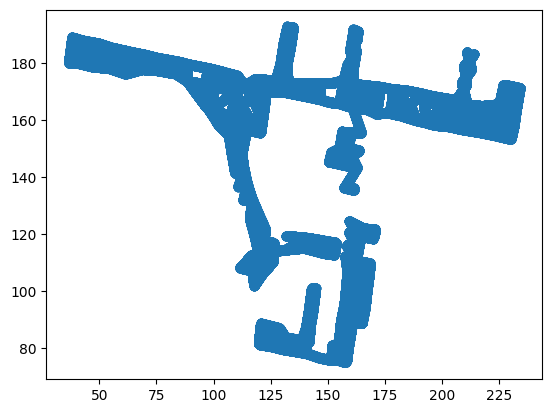

In [8]:
plt.scatter(magnPos[:,0],magnPos[:,1])